In [3]:
ENV["PYTHONPATH"]="/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
using Crystalline, MPBUtils, SymmetryBases, JLD2, PyPlot, DelimitedFiles, PyCall
using HDF5
using Crystalline.Bravais, Brillouin # To make new path in kspace
using StaticArrays
np = pyimport("numpy")
cm = 1/2.54;

In [7]:
# Below is basically the code in plotting_utilities.jl but we alter it slightly for our purposes here. 
shapely_point = pyimport("shapely.geometry").Point
shapely_polygon = pyimport("shapely.geometry.polygon").Polygon

function wigner_plot(flat::Crystalline.AbstractFourierLattice{2}, Rs::DirectBasis{2}, c::Cell{2}, isoval::Real;
              N::Integer=500,
              fig=nothing,
              ax=nothing, in_polygon::Bool=false, translation_vector::Vector{<:Real} = zeros(2), xyz::Union{AbstractRange, Nothing}=nothing)
    xyz = (isnothing(xyz) ? range(-0.75, 0.75, length=N) : xyz) #xyz is the grid on which the Fourier lattice is calculated
    vals = Crystalline.calcfouriergridded(xyz, flat, length(xyz))
    X, Y, vals = plotiso(xyz, vals, isoval, Rs, c, fig, ax, in_polygon, translation_vector)
    return X, Y, vals
end

# plot isocontour of data
function plotiso(xyz, vals, isoval::Real, Rs::DirectBasis{2}, c::Cell{2},
                 fig=nothing,
                 ax=nothing, in_polygon::Bool=false, translation_vector::Vector{<:Real}=zeros(2))
    fig = (isnothing(fig) && isnothing(ax)) ? plt.figure() : fig #If neither figure nor axis provided, make a new figure
    ax = isnothing(ax) ? fig.add_subplot(projection="rectilinear") : ax # If axis is not provided make a new axis

    tx, ty = translation_vector

    N = length(xyz)
    X = broadcast((x,y) -> (x+tx)*Rs[1][1] + (y+ty)*Rs[2][1], reshape(xyz,(1,N)), reshape(xyz, (N,1))) #optional tx, ty translations
    Y = broadcast((x,y) -> (x+tx)*Rs[1][2] + (y+ty)*Rs[2][2], reshape(xyz,(1,N)), reshape(xyz, (N,1)))
    if setting(c) !== Brillouin.CARTESIAN
        c = Brillouin.cartesianize(c)
    end
    cxs, cys = getindex.(c[1], 1), getindex.(c[1], 2)
    push!(cxs, cxs[1]); push!(cys, cys[1]) # To make a closed loop for the wigner-seitz cell
    ax.plot(cxs, cys, color="black", linewidth=0.8) # plot unit cell
    polygon = shapely_polygon(c[1])
    vals = -(vals .< isoval).*1000 .+ 500
    in_polygon_vals = (broadcast((x,y) -> polygon.contains(shapely_point(((x+tx)*Rs[1][1] + (y+ty)*Rs[2][1], (x+tx)*Rs[1][2] + (y+ty)*Rs[2][2]))), reshape(xyz,(1,N)), reshape(xyz, (N,1)))) # Determine whether points on the grid are within the first Brillouin zone

    vals = !in_polygon ? vals : (vals .* in_polygon_vals + 500*(1 .- in_polygon_vals)) #outside polygon, value of 500, inside polygon, value of -500 if below isovalue and value of 500 if above isovalue.
    plt.xlim(-1,1); plt.ylim(-1,1);
    !in_polygon ? ax.contourf(X,Y,vals; levels=(-1e6, 0, 1e6 ), cmap=plt.get_cmap("gray", 2)) : ax.contourf(X,Y,vals; levels=(-1e6, -1000, 50, 1e6 ), cmap=plt.get_cmap("gray", 3)) # Three values in cmap so we get a gray-white combination.

    ax.set_aspect("equal", adjustable="box")
    ax.set_axis_off()

    return X, Y, vals
end

plotiso (generic function with 5 methods)

In [62]:
# We try with c2 symmetric nodal points

In [5]:
# Revised Brillouin zone path
Rs, flat_bulk, isoval_bulk = lattice_from_mpbparams("../symeigs/input/dim2-sg2-6398-res64-tm.sh") # Real space parameters for nontrivial structure
_, flat_clad, isoval_clad = lattice_from_mpbparams("../symeigs/input/dim2-sg2-481-res64-tm.sh") # Real space parameters for trivial structure
    
Gs = reciprocalbasis(Rs) 
c = wignerseitz(Gs) # Brillouin zone
c_R = wignerseitz(Rs) # Real space wigner setiz cell
kp = irrfbz_path(2, Rs)
kp′ = KPath{2}( # points, paths, basis, setting
    merge(kp.points, Dict(:P₁ => c.verts[1], :P₆ => c.verts[6])),
    [[:Γ, :Y, :P₆, :A, :Γ, :B, :P₁, :A]],
    kp.basis, kp.setting
);

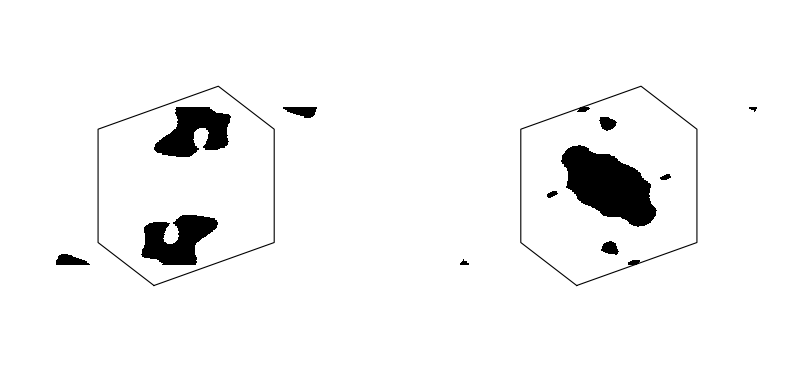

In [10]:
figure(figsize=(10, 5))
subplot(1, 2, 1)
xyz = range(-0.5, 0.5, length=128)
X_unit, Y_unit, vals_bulk = wigner_plot(flat_bulk, Rs, c_R, isoval_bulk, xyz=xyz, fig=gcf(), ax=gca())
subplot(1, 2, 2)
_, _, vals_clad = wigner_plot(flat_clad, Rs, c_R, isoval_clad, xyz=xyz, fig=gcf(), ax=gca());

In [6]:
# Write a file with the new kpoint path: 
dir = "./surface_states/input/"
kvecs_str = "kvecs=(list "
kpts = interpolate(kp′, 100).kpaths[1];
for kpt in kpts
    kpx, kpy = round.(kpt, digits=3)
    kvecs_str *= string("(vector3 ", kpt[1], " ", kpt[2], ") ")
end
kvecs_str *= ")"
open(dir*"kpts_new.sh", "w") do io
   write(io, kvecs_str) 
end;

# Write a file with the new kpoint path but only along B-P1 along which we zoom in: 
kp_B = kp′.points[:B]
kp_P1 = kp′.points[:P₁]
kdiff = kp_P1-kp_B
kvecs_str_BtoP1 = "kvecs=(list "

Nk = 500
for i in 0:Nk
    kpx, kpy = kp_B + kdiff*i/Nk
    kvecs_str_BtoP1 *= string("(vector3 ", kpx, " ", kpy, ") ")
end

kvecs_str_BtoP1 *= ")"

open(dir*"kpts_new_BtoP1.sh", "w") do io
   write(io, kvecs_str_BtoP1) 
end;

In [38]:
# Below is how we picked the above nontrivial structure. 
sgnum = 2
good_nodal_point_candidates = Dict{Tuple{String, Integer, Integer}, Float64}()
for mode in ["tm"]
    nodal_dir = "./output/sg$sgnum/eps3/$mode/"
    println("Mode: $mode"); flush(stdout)
    dispersion_dir = "../dispersions/output/sg$sgnum/eps3/$mode/";
    loaded_dispersion_data = load(dispersion_dir*"sg$sgnum-epsid3-res64-$mode.jld2")
    cumsummariesv = loaded_dispersion_data["cumsummariesv"];
    tot_count = 0
    for id in 1:10000
        real_id = id + (3-1)*10000
        (id % 100 == 0) && println("Id: $real_id. Count: $tot_count"); flush(stdout)
        multiplet_vec = zeros(3)
        cumsummaries = cumsummariesv[id]
        nodal_filename = "dim2-sg$sgnum-$(real_id)-res64-$mode-dispersion.out"
        isfile(nodal_dir*nodal_filename) || continue
        full_dispersion = sort(readdlm(nodal_dir*nodal_filename, ',')[:, 6:end], dims=2)
        for (multiplet, cumsummary) in enumerate(cumsummaries[1:min(length(cumsummaries), 3)])
            cumsummary.topology == NONTRIVIAL || continue
            bottom_band_idx = cumsummary.band[end]
            top_band_idx = bottom_band_idx + 1
            bottom_band_dispersion = full_dispersion[:, bottom_band_idx]
            
            len_dispersion = length(bottom_band_dispersion)
            top_band_dispersion = full_dispersion[:, top_band_idx]
            nodal_point = top_band_dispersion[argmin(top_band_dispersion - bottom_band_dispersion)]
            top_margin = minimum(top_band_dispersion) - nodal_point  
            top_margin >= 0 || continue 
            bottom_margin = nodal_point - maximum(bottom_band_dispersion)
            bottom_margin >= 0 || continue
            
            how_isolated = ((top_band_dispersion .- nodal_point).^2 + (bottom_band_dispersion .- nodal_point).^2)
            how_isolated = sqrt(sum(how_isolated) / len_dispersion)
            push!(good_nodal_point_candidates, (mode, real_id, multiplet) => how_isolated)
        end
        tot_count += 1
    end
end

Mode: tm
Id: 20100. Count: 66
Id: 20200. Count: 135
Id: 20300. Count: 209
Id: 20400. Count: 274
Id: 20500. Count: 341
Id: 20600. Count: 414
Id: 20700. Count: 484
Id: 20800. Count: 548
Id: 20900. Count: 612
Id: 21000. Count: 680
Id: 21100. Count: 746
Id: 21200. Count: 821
Id: 21300. Count: 884
Id: 21400. Count: 951
Id: 21500. Count: 1017
Id: 21600. Count: 1086
Id: 21700. Count: 1159
Id: 21800. Count: 1228
Id: 21900. Count: 1303
Id: 22000. Count: 1364
Id: 22100. Count: 1434
Id: 22200. Count: 1504
Id: 22300. Count: 1566
Id: 22400. Count: 1632
Id: 22500. Count: 1689
Id: 22600. Count: 1754
Id: 22700. Count: 1821
Id: 22800. Count: 1888
Id: 22900. Count: 1962
Id: 23000. Count: 2039
Id: 23100. Count: 2113
Id: 23200. Count: 2176
Id: 23300. Count: 2246
Id: 23400. Count: 2317
Id: 23500. Count: 2390
Id: 23600. Count: 2459
Id: 23700. Count: 2534
Id: 23800. Count: 2601
Id: 23900. Count: 2663
Id: 24000. Count: 2723
Id: 24100. Count: 2787
Id: 24200. Count: 2855
Id: 24300. Count: 2920
Id: 24400. Count:

In [45]:
good_nodal_point_candidates_filtered = filter(x->x[1][3] < 2, good_nodal_point_candidates) # Filter for first multiplet
max_separation = maximum([x[2] for x in good_nodal_point_candidates_filtered]) # Find most isolated nodal point (given by the metric in the cell above)
filter(x->x[2] == max_separation, good_nodal_point_candidates)

Dict{Tuple{String, Integer, Integer}, Float64} with 1 entry:
  ("tm", 26398, 1) => 0.116838

In [121]:
mode = "tm"
sgnum = 2
dispersion_dir = "../dispersions/output/sg$sgnum/eps3/$mode/";
loaded_dispersion_data = load(dispersion_dir*"sg$sgnum-epsid3-res64-$mode.jld2");

In [123]:
cumsummariesv = loaded_dispersion_data["cumsummariesv"]
dispersionsv = loaded_dispersion_data["dispersionsv"];

In [126]:
idx = 6398 # The nontrivial structure
cumsummaries = cumsummariesv[idx]
dispersions = dispersionsv[idx];

In [128]:
cumsummaries[1:5] # Find the symmetry vectors and verify the nontriviality 

5-element Vector{BandSummary}:
 1-band (nontrivial): [Y₂, B₁, A₁, Γ₁]
 2-band (trivial): [Y₁+Y₂, B₁+B₂, A₁+A₂, Γ₁+Γ₂]
 3-band (nontrivial): [2Y₁+Y₂, 2B₁+B₂, A₁+2A₂, 2Γ₁+Γ₂]
 4-band (trivial): [2Y₁+2Y₂, 2B₁+2B₂, 2A₁+2A₂, 2Γ₁+2Γ₂]
 5-band (nontrivial): [3Y₁+2Y₂, 2B₁+3B₂, 3A₁+2A₂, 3Γ₁+2Γ₂]

In [10]:
# Find a good cladding candidate
good_candidates_cladding = Integer[]
good_candidates_cladding_dict = Dict{Integer, Float64}()

min_e = 0.26 # Just below the dirac point (see below for where we calculate the dirac point frequency)
max_e = 0.28 # Just above the dirac point (see below for where we calculate the dirac point frequency)
for (idx, (cumsummaries, dispersions)) in enumerate(zip(cumsummariesv, dispersionsv))
    good_candidate = false
    all(x-> x < min_e || x > max_e, dispersions) || continue
    good_candidate= true
    for (mult_idx, cumsummary) in enumerate(cumsummaries)
        top_band = cumsummary.band[end]
        maximum(dispersions[:, top_band]) < min_e || continue
        if cumsummary.topology != TRIVIAL 
            good_candidate = false 
        else
            good_candidate = true
        end
    end
    good_candidate && push!(good_candidates_cladding, idx)
    
    below_emin = filter(x-> x < min_e, dispersions)
    above_emax = filter(x-> x > max_e, dispersions)
    push!(good_candidates_cladding_dict , idx => minimum([(min_e .- below_emin)..., (above_emax .- max_e)...] ))
end
filter(x-> x[2] == maximum(values(good_candidates_cladding_dict)), good_candidates_cladding_dict)

Dict{Integer, Float64} with 1 entry:
  481 => 0.03522

In [13]:
# We check that the cladding candidate still gives a trivial gap when the rvectors are changed to be commensurate with the nontrivial structure
sg = 2
id = 20481
dir = "./surface_states/output/"
symeigsd, lgd = read_symdata("dim2-sg$sg-$(id)-res64-$mode", dir = dir)
fixup_gamma_symmetry!(symeigsd, lgd, Symbol(uppercase(mode)))
lgirsd = pick_lgirreps(lgd)
brs = bandreps(2, 2)
summaries = analyze_symmetry_data(symeigsd, lgirsd, brs)
cumsummaries = cumsum(summaries);

In [54]:
summaries[1:5] # Checking the triviality 

5-element Vector{BandSummary}:
 1-band (trivial): [Y₁, B₁, A₁, Γ₁]
 1-band (trivial): [Y₂, B₂, A₂, Γ₂]
 1-band (nontrivial): [Y₂, B₂, A₂, Γ₁]
 1-band (nontrivial): [Y₁, B₁, A₁, Γ₂]
 1-band (trivial): [Y₂, B₂, A₁, Γ₁]

In [40]:
original_dir = "../symeigs/output/sg2/eps3/tm/"
#filename = "dim2-sg2-26398-res64-tm-supercell-epsilon.h5"
filename = "dim2-sg2-26398-res64-tm-epsilon.h5"

epsilon_original = h5open(original_dir*filename, "r") do file
    read(file, "data-new")
end;

original_rvecs = h5open(original_dir*filename, "r") do file
    read(file, "lattice vectors")
end;
# Original lattice vectors 

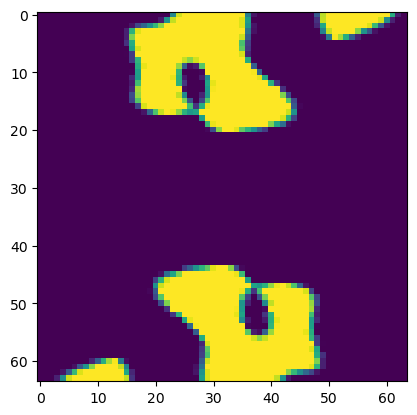

PyObject <matplotlib.image.AxesImage object at 0x7f88121a09a0>

In [236]:
imshow(epsilon_original)

In [12]:
dir = "./surface_states/"
#filename = "dim2-sg2-26398-res64-tm-supercell-epsilon.h5"
filename = "dim2-sg2-26398-res16-tm-supercell-epsilon.h5"

epsilon_supercell = h5open(dir*filename, "r") do file
    read(file, "data-new")
end;
new_rvecs = h5open(dir*filename, "r") do file
    read(file, "lattice vectors")
end;
epsilon_supercell_unaltered = h5open(dir*filename, "r") do file
    read(file, "data")
end;

In [13]:
dir = "./surface_states/"
dpwrs = Matrix{Float64}[]
dpwrs_new = Matrix{Float64}[]

for band_idx in [100, 101] # The two edge states
    filename = "dim2-sg2-26398-res16-tm-supercell-dpwr.k102.b$(band_idx).tm.h5"

    dpwr = h5open(dir*filename, "r") do file
        read(file, "data")
    end
    dpwr_new = h5open(dir*filename, "r") do file
        read(file, "data-new")
    end
    dpwr_rvec = h5open(dir*filename, "r") do file
        read(file, "lattice vectors")
    end
    println(dpwr_rvec)

    push!(dpwrs, dpwr)
    push!(dpwrs_new, dpwr_new)
end;

[0.6826724167535964 100.0 0.0; 0.8874647409418691 0.0 0.0; 0.0 0.0 1.0]
[0.6826724167535964 100.0 0.0; 0.8874647409418691 0.0 0.0; 0.0 0.0 1.0]


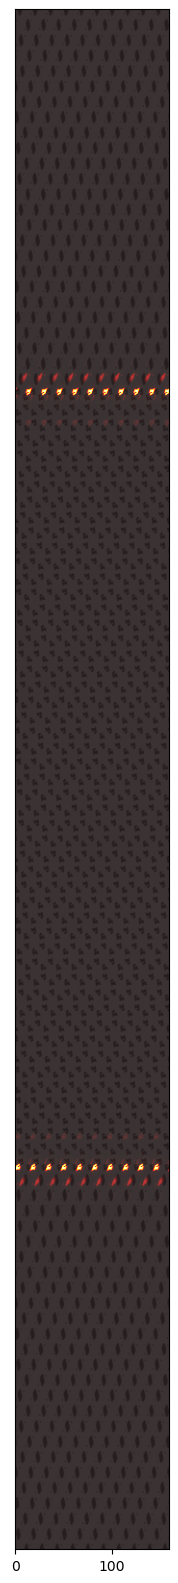

(Any[], Any[])

In [12]:
figure(figsize=(20, 20))
imshow(hcat([epsilon_supercell for i in 1:10]...), cmap="Greys", alpha=0.4)
imshow(hcat([sum(dpwrs) for i in 1:10]...), cmap="hot", alpha=0.8)
yticks([])

In [21]:
n = 0
supercellx=1
new_cell = Cell([SVector{2}([-0.5*supercellx, -0.5]-[0, 1]*n), SVector{2}([0.5*supercellx, -0.5]-[0, 1]*n), SVector{2}([0.5*supercellx, 0.5]+[0, 1]*n), SVector{2}([-0.5*supercellx, 0.5]+[0, 1]*n), SVector{2}([1., 0.]), SVector{2}([1., 0.])], wigner_cell.faces, wigner_cell.basis, wigner_cell.setting)
new_cell[1]

6-element Vector{SVector{2, Float64}}:
 [-0.5, -0.5]
 [1.0, 0.0]
 [1.0, 0.0]
 [-0.5, 0.5]
 [0.5, 0.5]
 [0.5, -0.5]

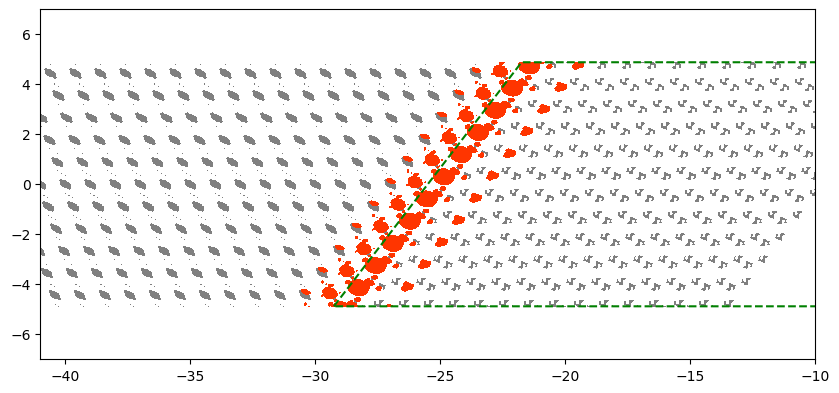

In [24]:
dpwr_data = sum(dpwrs)
n = 5
figure(figsize=(10, 10))
max_data = maximum(dpwr_data) 
wigner_cell = wignerseitz(Rs)
supercellx = 51 # 51 unit cells of nontrivial bulk
supercelly = 1
x = range(-0.5, 0.5, length=1600)
y = range(-0.5, 0.5, length=16)

vert_idxs = [1, 4, 5, 6]
new_cell = Cell([SVector{2}([-0.5*supercellx, -0.5]-[0, 1]*n), SVector{2}([0.5*supercellx, -0.5]-[0, 1]*n), SVector{2}([0.5*supercellx, 0.5]+[0, 1]*n), SVector{2}([-0.5*supercellx, 0.5]+[0, 1]*n), SVector{2}([1., 0.]), SVector{2}([1., 0.])], wigner_cell.faces, wigner_cell.basis, wigner_cell.setting)
Rsprime = [Rs[1]*100, Rs[2]]
new_cell_cartesian = Brillouin.cartesianize(new_cell)
c = new_cell_cartesian
cxs, cys = (getindex.(c[1][vert_idxs], 1), getindex.(c[1][vert_idxs], 2)) 
    
push!(cxs, cxs[1]); push!(cys, cys[1]) # push the first vertex to list of vertices so as to close the loop


X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(x, (1, 1600)), reshape(y, (16, 1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(x, (1, 1600)), reshape(y, (16, 1)));

for i in -25:-10
    for j in -n:n
        contourf(X_unit .+ i .+ j*Rs[2][1], Y_unit .+ j*Rs[2][2], vals_bulk, levels=(-1e6, -1000, 50, 1e6 ), cmap=plt.get_cmap("gray", 3))
    end
end

for i in -50:-26
    for j in -n:n
        contourf(X_unit .+ i .+ j*Rs[2][1], Y_unit .+ j*Rs[2][2], vals_clad, levels=(-1e6, -1000, 50, 1e6 ), cmap=plt.get_cmap("gray", 3))
    end
end

for j in -n:n
    contourf(X.+ j*Rs[2][1], Y.+ j*Rs[2][2], transpose(dpwr_data), cmap=plt.get_cmap("hot",10), levels=(max_data/100, max_data), alpha=1)
end
plot(cxs, cys, color="green", linestyle="dashed")
#ylim(-0.6, 0.6)
#gca().set_aspect("equal")
#xlim(-35, -20)
xlim(-41, -10)
#ylim(-4, 4)
ylim(-7, 7)
gca().set_aspect("equal")
#savefig("Edge_State_ContourPlot.pdf")

In [30]:
mode = "tm"
sgnum = 2
nodal_dir = "./output/sg$sgnum/eps3/$mode/"
idx = 6398
real_id = idx+20000
nodal_filename = "dim2-sg$sgnum-$(real_id)-res64-$mode-dispersion.out"
full_dispersion = sort(readdlm(nodal_dir*nodal_filename, ',')[:, 6:end], dims=2);
ks = Vector{Vector{Float64}}()
N = 50

for i in 1:N+1
    for j in 1:N+1
        kx = -0.5+1*(i-1)/N 
        ky = 0.5*(j-1)/N 
        push!(ks, [kx, ky])
    end
end
smaller_full_dispersion = full_dispersion[:, 1:2];

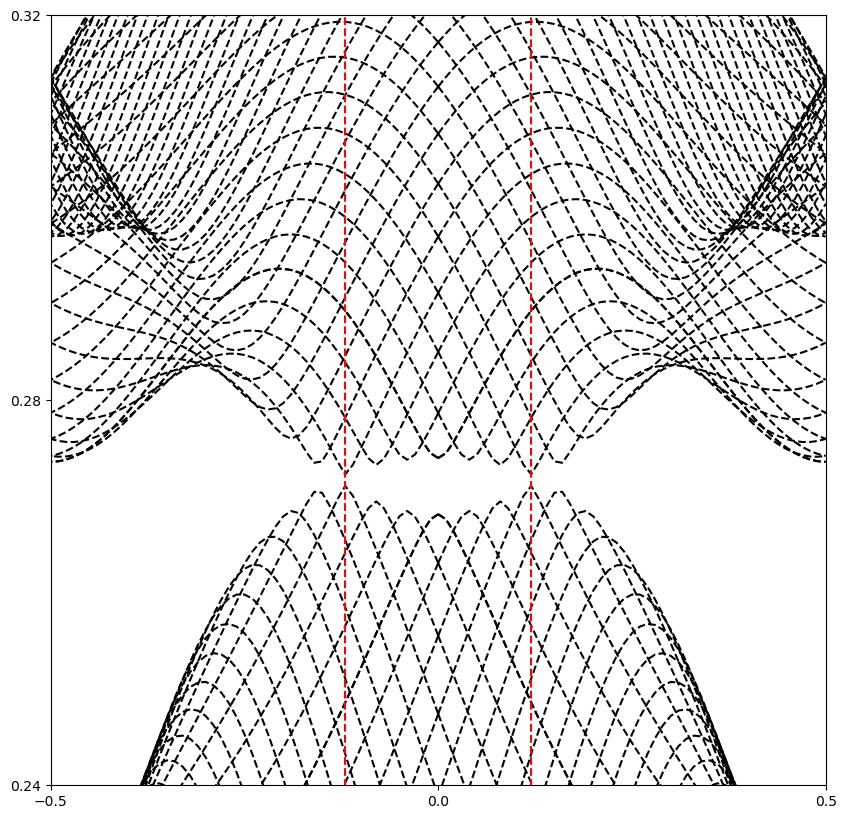

In [36]:
figure(figsize=(10, 10))
kyrange = range(0, 0.5, length=51)
kyrange_neg = range(0, -0.5, length=51) # Because we only looked at half of the Brillouin zone
linestyle="dashed"
for n in 0:50
    disp_at_ky1 = smaller_full_dispersion[1+n*51:51*(n+1), 1]
    disp_at_ky2 = smaller_full_dispersion[1+n*51:51*(n+1), 2]
    plot(kyrange, disp_at_ky1, color="black", linestyle=linestyle)
    plot(kyrange, disp_at_ky2, color="black", linestyle=linestyle)
    plot(kyrange_neg, disp_at_ky1, color="black", linestyle=linestyle)
    plot(kyrange_neg, disp_at_ky2, color="black", linestyle=linestyle)
end
ylim(0.24, 0.32)
vlines([0.12], 0, 0.5, color="red", linestyle=linestyle)
vlines([-0.12], 0, 0.5, color="red", linestyle=linestyle)
xlim(-0.5, 0.5);
xticks([-0.5, 0, 0.5])
yticks([0.24, 0.28, 0.32]);

In [37]:
dirac_idx = argmin(diff(full_dispersion, dims=2)[:, 1])

166

In [38]:
println("Dirac point located at: $(ks[dirac_idx])")

Dirac point located at: [-0.44, 0.12]


In [39]:
println("Dirac point frequency: $(full_dispersion[166, 1])")

Dirac point frequency: 0.271094


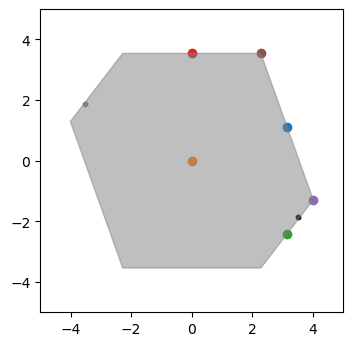

A
Γ
B
Y
P₁
P₆


In [40]:
figure(figsize=(10*cm, 10*cm))
xs = Float64[]
ys = Float64[]

verts = wignerseitz(Gs).verts;
faces = wignerseitz(Gs).faces;
for vert in verts
    x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
   #scatter(x, y, color="black")
    push!(xs, x)
    push!(ys, y)
end

for (klab, k) in kp′.points
    println(klab)
    x, y = Gs[1]*k[1] + Gs[2]*k[2]
    scatter(x, y, label=String(klab))
end

for i in 1
    for j in 0
        x, y = Gs[1]*(ks[dirac_idx][1]+i)+Gs[2]*(ks[dirac_idx][2]+j)
        scatter(x, y, label="NP", color="black", s=10)
        scatter(-x, -y, label="NP",color="grey", s=10)
    end
end

fill(xs, ys, alpha=0.5, color="grey")
polygon = shapely_polygon([[x, y] for (x, y) in zip(xs, ys)])
xlim(-5, 5)
ylim(-5, 5)
gca().set_aspect("equal")
#legend()
#savefig("Brillouin_Zone.pdf")

In [41]:
#Dispersions along new path (for better plotting)
new_cladding_dispersion = readdlm("surface_states/output/dim2-sg2-20481-res64-tm-fulldispersion-dispersion.out", ',')[:, 6:end];
new_bulk_dispersion = readdlm("surface_states/output/dim2-sg2-26398-res64-tm-fulldispersion-dispersion.out", ',')[:, 6:end];
bulk_B_toP1_dispersion = readdlm("surface_states/output/dim2-sg2-26398-res64-tm-fulldispersionBtoP1-dispersion.out", ',')[:, 6:end];

In [42]:
#Check that kpoints are indeed what was calculated
new_cladding_kpoints = readdlm("surface_states/output/dim2-sg2-20481-res64-tm-fulldispersion-dispersion.out", ',')[:, 2:3];
new_bulk_kpoints = readdlm("surface_states/output/dim2-sg2-26398-res64-tm-fulldispersion-dispersion.out", ',')[:, 2:3];

In [43]:
brillouin_xticks = Integer[]
brillouin_xtick_labels = String[]
for (key, val) in kp′.points 
    idxs = findall(x -> isapprox(x, val), kpts)
    println("Indices for kpoint $(key) are: $(idxs) ")
    for idx in idxs 
        push!(brillouin_xticks, idx)
        push!(brillouin_xtick_labels, String(key))
    end
end

Indices for kpoint A are: [42, 98] 
Indices for kpoint Γ are: [1, 58] 
Indices for kpoint B are: [78] 
Indices for kpoint Y are: [18] 
Indices for kpoint P₁ are: [85] 
Indices for kpoint P₆ are: [29] 


In [44]:
@assert all(x-> isless(x, 0.272309), new_bulk_dispersion[:, 1])
@assert all(x-> isless(0.272309, x), new_bulk_dispersion[:, 2])

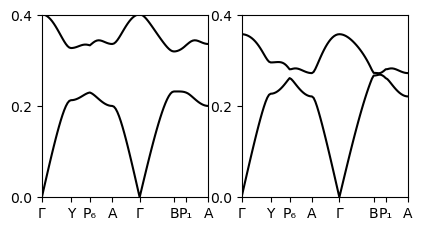

In [53]:
cm = 1/2.54
figure(figsize=(12*cm, 6*cm))
subplot(1, 2, 1)
plot(1:length(kpts), new_cladding_dispersion, color="black")
ylim(0, 0.4)
yticks([0, 0.2, 0.4])
xlim(1, length(kpts))
xticks(brillouin_xticks, brillouin_xtick_labels);
ax = gca()
#ax.spines["top"].set_visible(false)
#ax.spines["right"].set_visible(false)
#ax.spines["bottom"].set_visible(false)
#ax.spines["left"].set_visible(false)


subplot(1, 2, 2)
plot(1:length(kpts), new_bulk_dispersion, color="black")
ylim(0, 0.4)
yticks([0, 0.2, 0.4])
xlim(1, length(kpts))
xticks(brillouin_xticks, brillouin_xtick_labels);
#hlines([0.272309], 1, 100, color="red")
ax = gca()
#ax.spines["top"].set_visible(false)
#ax.spines["right"].set_visible(false)
#ax.spines["bottom"].set_visible(false)
#ax.spines["left"].set_visible(false)
savefig("Stable_Bulk_Bands.pdf")

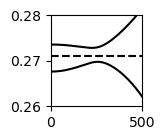

In [143]:
figure(figsize=(3*cm, 3*cm))
plot(bulk_B_toP1_dispersion[:, 1:2], color="black")
hlines([0.271094], 0, 500, color="black", linestyle="dashed")
xlim(0, 500)
ylim(0.26, 0.28)
xticks([0, 500])
savefig("Stable_Bulk_Bands_B_to_P1.pdf")

In [46]:
# The supercell spectrum
filename = "dim2-sg2-26398-res64-tm-dispersion.out"
dir = "./surface_states/output/"
dispersion = readdlm(dir*filename, ',')[:, 6:end];
dispersion_doubled = vcat(dispersion, dispersion[101:-1:1, :])

filename = "dim2-sg2-26398-res16-tm-dispersion.out"
dir = "./surface_states/output/"
dispersion16 = readdlm(dir*filename, ',')[:, 6:end];
dispersion16_doubled = vcat(dispersion16[102:-1:2, :], dispersion16);

edge_idxs16 = findall(x-> 0.25 < x < 0.27, dispersion16[end, :])
edge_idxs = findall(x-> 0.25 < x < 0.27, dispersion[end, :]);

In [52]:
filename = "dim2-sg2-26398-res16-tm-dispersion.out"
dir = "./surface_states/output/"
kpts16_ribbon = readdlm(dir*filename, ',')[:, 3];
kpts16_ribbon_doubled = [-kpts16_ribbon[102:-1:2]..., kpts16_ribbon...];

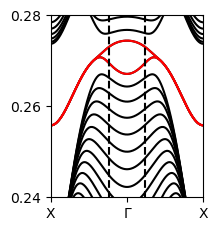

In [195]:
figure(figsize=(5*cm, 6*cm))
plot(dispersion16_doubled, color="black")
plot(dispersion16_doubled[:, edge_idxs16], color="red")
#vlines([24], 0, 0.5)
xlim(0, 202)
xticks([0, 101, 202], ["X", "Γ", "X"])
vlines([125], 0, 0.5, linestyle="dashed", color="black")
vlines([77], 0, 0.5, linestyle="dashed", color="black")

ylim(0.24, 0.28);
yticks([0.24, 0.26, 0.28]);
savefig("Stable_Edge_Bands.pdf")
#ylim(0, 0.001)

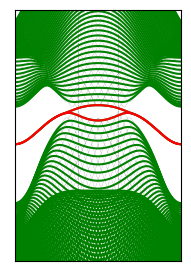

In [107]:
ax_height = 6.3853*cm
ax_width = 4.2273*cm

fig = figure()

color_bulk = "grey"
kyrange = range(0, 0.5, length=51)
kyrange_neg = range(0, -0.5, length=51)
linestyle="dashed"
linewidth = 0.2
linewidth2 = 0.4
linewidth3 = 0.4

for n in 0:50
    disp_at_ky1 = smaller_full_dispersion[1+n*51:51*(n+1), 1]
    disp_at_ky2 = smaller_full_dispersion[1+n*51:51*(n+1), 2]
    plot(kyrange, disp_at_ky1, color=color_bulk, linestyle=linestyle, linewidth=linewidth)
    plot(kyrange, disp_at_ky2, color=color_bulk, linestyle=linestyle, linewidth=linewidth)
    plot(kyrange_neg, disp_at_ky1, color=color_bulk, linestyle=linestyle, linewidth=linewidth)
    plot(kyrange_neg, disp_at_ky2, color=color_bulk, linestyle=linestyle, linewidth=linewidth)
end
ylim(0.2, 0.32)
#vlines([0.12], 0, 0.5, color="red", linestyle=linestyle, linewidth=linewidth3)
#vlines([-0.12], 0, 0.5, color="red", linestyle=linestyle, linewidth=linewidth3)
vlines([0.12], 0, 0.5, color="grey", linestyle=linestyle, linewidth=linewidth3)
vlines([-0.12], 0, 0.5, color="grey", linestyle=linestyle, linewidth=linewidth3)

xlim(-0.5, 0.5)

#plot(kpts16_ribbon_doubled, dispersion16_doubled, color="green", linewidth=linewidth, alpha=0.4)
plot(kpts16_ribbon_doubled, dispersion16_doubled, color="green")

#plot(kpts16_ribbon_doubled, dispersion16_doubled[:, edge_idxs16], color="red", linewidth=linewidth2)
plot(kpts16_ribbon_doubled, dispersion16_doubled[:, edge_idxs16], color="red")
#xticks([-0.5, 0, 0.5], ["X", "Γ", "X"])
#yticks([0.2, 0.26, 0.32])
xticks([])
yticks([])

r = fig.subplotpars.right
l = fig.subplotpars.left
t = fig.subplotpars.top
b = fig.subplotpars.bottom

fig.set_size_inches(ax_width/(r-l), ax_height/(t-b))

savefig("Stable_Edge_Bands_Superimposed_with_Bulk.pdf")
